### Load packages

In [3]:
using Revise, Reachability, LazySets, MathematicalSystems, Dates

In [4]:
now()

2019-10-27T08:44:09.718

### Running Example

In [10]:
# Example from Althoff's thesis, section 3.2.3
A = [-1 -4  0  0  0;
      4 -1  0  0  0;
      0  0 -3  1  0;
      0  0  -1 -3 0;
      0  0   0 0  -2.]
X0 = Hyperrectangle(low=fill(0.9, 5), high=fill(1.1, 5));

## Upstream (type-unstable) algorithm

In [28]:
S = LinearContinuousSystem(A)
P = InitialValueProblem(S, X0)
opts = Options(:T=>5.0)
opts_algo = Options(:δ=>0.01, :vars=>[2, 3]);

In [29]:
sol = solve(P, opts, op=BFFPSV18(opts_algo));

In [30]:
sol.options[:partition]

5-element Array{Array{Int64,1},1}:
 [1]
 [2]
 [3]
 [4]
 [5]

In [31]:
sol.options[:block_options_init]

5-element Array{Type{#s123} where #s123<:LazySet,1}:
 Interval
 Interval
 Interval
 Interval
 Interval

In [32]:
dim(set(sol.Xk[1])) # it is already projected as it has dimension 2

2

In [33]:
typeof(sol.Xk[1])

SparseReachSet{CartesianProductArray{Float64,LazySet{Float64}}}

In [34]:
set(sol.Xk[1]) # by default, one dimensional sets (Intervals) are used
# moreover, the container array is abstract, note LazySets{Float64}[...]

CartesianProductArray{Float64,LazySet{Float64}}(LazySet{Float64}[Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.899999, 1.13301]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.881916, 1.10001])])

In [35]:
set(sol.Xk[20])

CartesianProductArray{Float64,LazySet{Float64}}(LazySet{Float64}[Interval{Float64,IntervalArithmetic.Interval{Float64}}([1.02161, 1.30582]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.581826, 0.728369])])

In [36]:
sol.Xk[1].dimensions # variables that are actually computed

2-element Array{Int64,1}:
 2
 3

In [19]:
using BenchmarkTools

In [37]:
@btime solve($P, $opts, op=BFFPSV18($opts_algo));
#   24.105 ms (13672 allocations: 922.22 KiB) for a 4d system
#   28.731 ms (77277 allocations: 4.01 MiB) for Example 3.2.3 in Althoff's thesis

  28.731 ms (77277 allocations: 4.01 MiB)


In [24]:
using Plots

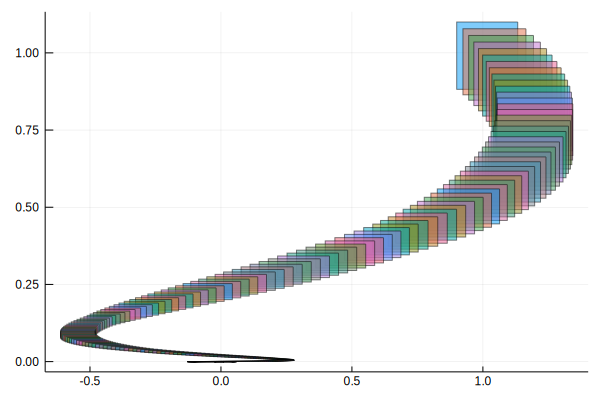

In [38]:
plot([set(sol.Xk[i]) for i in eachindex(sol.Xk)])

In [39]:
length(sol.Xk)

500

## Type-stable algorithm

You should run the functions in the Appendix before running this section.

In [47]:
S = LinearContinuousSystem(A)
P = InitialValueProblem(S, X0)
opts = Options(:T => 5.0,
               :δ => 0.01,
               :N => 500,  # el N se puede sacar de T y de delta
               :vars=>[1, 2],
               :partition => [[1], [2], [3], [4], [5]],
               :set_type => Interval{Float64, IA.Interval{Float64}},
               :row_blocks => [[2], [3]],
               :column_blocks => [[1], [2], [3], [4]],
               :num_type => Float64,
               :block_indices => [2, 3]);
# varias de las opciones anteriores se pueden deducir de otras!

In [50]:
sol = solve_BFFPSV18(P, opts);

In [52]:
@btime solve_BFFPSV18($P, $opts);
# 2.530 ms (29234 allocations: 1.93 MiB) for Example 3.2.3 in Althoff's thesis

  2.552 ms (29234 allocations: 1.93 MiB)


In [64]:
# RESULTS:

#   566.383 μs (6009 allocations: 428.06 KiB) for a random 4d system with N = 100 steps
# for N = 100 time steps
# 24e-3 / 566e-6 # this is aprox 40x faster than the upstream code for a random 4d system with N = 100 steps

# 28.7 / 2.55 ---> 10x faster with solve_BFFPSV18

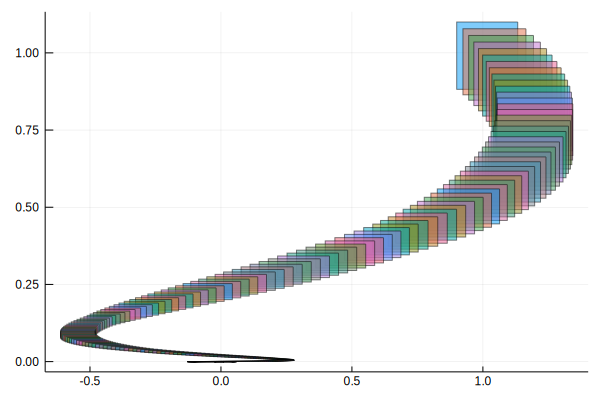

In [56]:
plot([set(sol[i]) for i in eachindex(sol)])

In [59]:
set(sol[1]).array
# solution with upsteam code
#CartesianProductArray{Float64,LazySet{Float64}}(LazySet{Float64}[
#        Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.899999, 1.13301]), 
#        Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.881916, 1.10001])])

2-element Array{Interval{Float64,IntervalArithmetic.Interval{Float64}},1}:
 Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.899999, 1.13301])
 Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.881916, 1.10001])

In [60]:
set(sol[20]).array
# solution with upstream code
#CartesianProductArray{Float64,LazySet{Float64}}(LazySet{Float64}[
#        Interval{Float64,IntervalArithmetic.Interval{Float64}}([1.02161, 1.30582]), 
#        Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.581826, 0.728369])])
#

2-element Array{Interval{Float64,IntervalArithmetic.Interval{Float64}},1}:
 Interval{Float64,IntervalArithmetic.Interval{Float64}}([1.02161, 1.30582])  
 Interval{Float64,IntervalArithmetic.Interval{Float64}}([0.581826, 0.728369])

## Interval specialization

If the row-blocks and column-blocks are of size one, we can use interval aritmetic in place of overapproximating the Minkowski sum array.

In [78]:
# INTERVALOS
function reach_homog!(res, ϕ, Xhat0, δ, N, vars, block_indices, row_blocks, column_blocks,
                      NUM, ST::Type{<:Interval})

    # store first element
    ti, tf = 0.0, δ
    R0 = ReachSet(CartesianProductArray(Xhat0[block_indices]), ti, tf)
    res[1] = SparseReachSet(R0, vars)

    # cache matrix
    ϕpowerk = copy(ϕ)
    ϕpowerk_cache = similar(ϕ)

    # preallocate overapproximated Minkowski sum for each row-block
    Xhatk = Vector{ST}(undef, length(row_blocks))

    @inbounds for k in 2:N
        for (i, bi) in enumerate(row_blocks) # loop over row-blocks of interest
            Xhatk[i] = Interval(zero(NUM), zero(NUM))
            for (j, bj) in enumerate(column_blocks) # loop over all column-blocks
                Xhatk[i] += Interval(ϕpowerk[bi[1], bj[1]] * Xhat0[j].dat)
            end
        end
        ti = tf
        tf += δ
        Rk = ReachSet(CartesianProductArray(copy(Xhatk)), ti, tf)
        res[k] = SparseReachSet(Rk, vars)

        mul!(ϕpowerk_cache, ϕpowerk, ϕ)
        copyto!(ϕpowerk, ϕpowerk_cache)
    end
    return res
end

reach_homog! (generic function with 2 methods)

In [79]:
sol = solve_BFFPSV18(P, opts);

In [80]:
@btime solve_BFFPSV18($P, $opts);

  693.289 μs (3285 allocations: 198.81 KiB)


In [ ]:
# RESULTS

# With interval arithmetic ops,

#   677.427 μs (3286 allocations: 198.92 KiB)
# we get 2.55e-3 / 677e-6 = 3.77 speedup wrt the generic version

# moreover, the speedup wrt upsteam is: 28.7e-3 / 677e-6 = 42.39290989660266

In [77]:
2.55e-3 / 677e-6

3.766617429837519

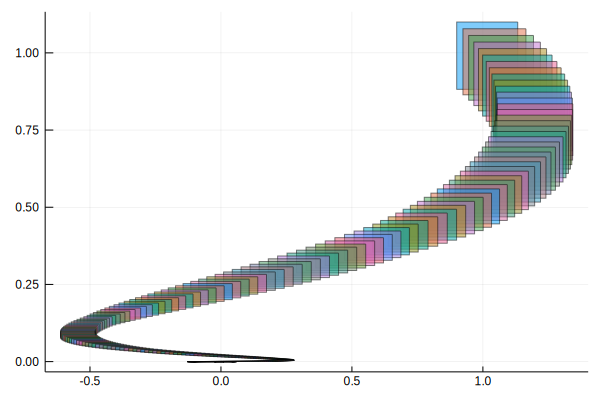

In [65]:
plot([set(sol[i]) for i in eachindex(sol)])

## Using static arrays

In [84]:
using StaticArrays

In [107]:
# INTERVALOS
function reach_homog!(res, ϕ, Xhat0, δ, N, vars, block_indices, row_blocks, column_blocks,
                      NUM, ST::Type{<:Interval})

    # store first element
    ti, tf = 0.0, δ
    R0 = ReachSet(CartesianProductArray(Xhat0[block_indices]), ti, tf)
    res[1] = SparseReachSet(R0, vars)

    # cache matrix
    ϕ = MMatrix{5, 5, Float64}(ϕ) # para prueba
    ϕpowerk = copy(ϕ)
    ϕpowerk_cache = similar(ϕ)

    # preallocate overapproximated Minkowski sum for each row-block
    Xhatk = Vector{ST}(undef, length(row_blocks))

    @inbounds for k in 2:N
        for (i, bi) in enumerate(row_blocks) # loop over row-blocks of interest
            Xhatk[i] = Interval(zero(NUM), zero(NUM))
            for (j, bj) in enumerate(column_blocks) # loop over all column-blocks
                Xhatk[i] += Interval(ϕpowerk[bi[1], bj[1]] * Xhat0[j].dat)
            end
        end
        ti = tf
        tf += δ
        Rk = ReachSet(CartesianProductArray(copy(Xhatk)), ti, tf)
        res[k] = SparseReachSet(Rk, vars)

        mul!(ϕpowerk_cache, ϕpowerk, ϕ)
        copyto!(ϕpowerk, ϕpowerk_cache)
    end
    return res
end

reach_homog! (generic function with 2 methods)

In [111]:
sol = solve_BFFPSV18(P, opts);

In [112]:
@btime solve_BFFPSV18($P, $opts);

  551.871 μs (3285 allocations: 198.66 KiB)


In [ ]:
# normal: 685.712 μs (3285 allocations: 198.81 KiB)
# with ϕ = MMatrix{5, 5, Float64}(ϕ) : 
#   537.982 μs (3285 allocations: 198.66 KiB)

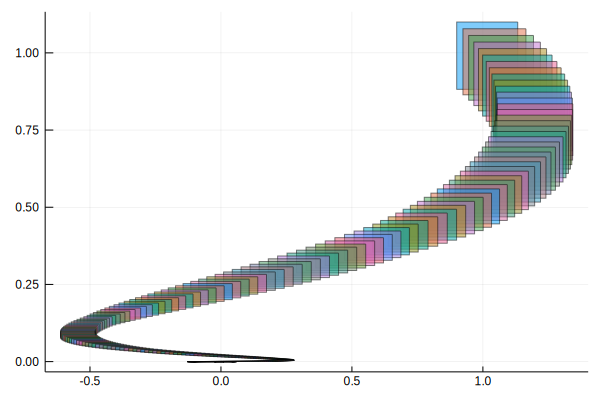

In [95]:
plot([set(sol[i]) for i in eachindex(sol)])

### Appendix

In [42]:
import IntervalArithmetic
const IA = IntervalArithmetic
using LinearAlgebra

In [43]:
function discretizar_homog(S, δ)
    A, X0 = S.s.A, S.x0
    ϕ = Reachability.ReachSets.exp_Aδ(A, δ, exp_method="base")
    Phi2Aabs = Reachability.ReachSets.Φ₂(abs.(A), δ, exp_method="base")
    Einit = symmetric_interval_hull(Phi2Aabs * symmetric_interval_hull((A * A) * X0))
    Ω0 = Reachability.ReachSets._discretize_interpolation_homog(X0, ϕ, Einit, Val(:lazy))
    Pdiscr = ConstrainedLinearDiscreteSystem(ϕ, stateset(S.s))
    return InitialValueProblem(Pdiscr, Ω0)
end

# @btime Reachability.ReachSets.discretize_interpolation(Pnorm, opts_algo[:δ])
# 94.589 μs (179 allocations: 49.34 KiB)

# @btime discretizar_homog(Pnorm, opts_algo[:δ])
# 66.329 μs (179 allocations: 49.34 KiB)

function discretization(P, δ)
    S = Reachability.normalize(P.s)
    P = InitialValueProblem(S, P.x0)
    return discretizar_homog(P, δ)
end

discretization (generic function with 1 method)

In [44]:
# uniform block partition
function _decompose(S::LazySet{N}, partition::AbstractVector{<:AbstractVector{Int}}, block_options::Type{T}) where {N, T<:LazySet}
    n = dim(S)
    result = Vector{T}(undef, length(partition))

    @inbounds for (i, block) in enumerate(partition)
        result[i] = project(S, block, block_options, n)
    end
    return CartesianProductArray(result)
end

# Comment:
# LazySets.decompose(Ω0, [[1], [2], [3], [4]], Interval)
# returns a CPA of LazySets, even for the case where the set type in the partition are constant (!)
# the function _decompose defined above returns a concretely defined CPA

_decompose (generic function with 1 method)

In [45]:
# GENERICO
function reach_homog!(res, ϕ, Xhat0, δ, N, vars, block_indices, row_blocks, column_blocks, NUM, ST)
 
    # store first element
    ti, tf = 0.0, δ
    R0 = ReachSet(CartesianProductArray(Xhat0[block_indices]), ti, tf)
    res[1] = SparseReachSet(R0, vars)

    # cache matrix
    ϕpowerk = copy(ϕ)
    ϕpowerk_cache = similar(ϕ)

    # preallocate buffer for each row-block
    buffer = Vector{LazySets.LinearMap{NUM, ST, NUM, Matrix{NUM}}}(undef, length(column_blocks))

    # preallocate overapproximated Minkowski sum for each row-block
    Xhatk = Vector{ST}(undef, length(row_blocks))

    @inbounds for k in 2:N
        for (i, bi) in enumerate(row_blocks) # loop over row-blocks of interest
            for (j, bj) in enumerate(column_blocks) # loop over all column-blocks
                buffer[j] = ϕpowerk[bi, bj] * Xhat0[j]
            end
            Xhatk[i] = overapproximate(MinkowskiSumArray(buffer), ST)
        end
        ti = tf
        tf += δ
        Rk = ReachSet(CartesianProductArray(copy(Xhatk)), ti, tf)
        @inbounds res[k] = SparseReachSet(Rk, vars)

        mul!(ϕpowerk_cache, ϕpowerk, ϕ)
        copyto!(ϕpowerk, ϕpowerk_cache)
    end
    return res
end

reach_homog! (generic function with 1 method)

In [49]:
const IVP = InitialValueProblem
const LCS = LinearContinuousSystem

# typeof(P)
# InitialValueProblem{LinearContinuousSystem{Float64,Array{Float64,2}},Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}

function solve_BFFPSV18(P::IVP{<:LCS, <:LazySet}, opts)
    
    # unwrap some options
    vars = opts[:vars]
    δ = opts[:δ]
    N = opts[:N]
    NUM = opts[:num_type]
    ST = opts[:set_type]
    partition = opts[:partition]
    block_indices = opts[:block_indices]
    column_blocks = opts[:column_blocks]
    row_blocks = opts[:row_blocks]

    # normalize and discretize system
    Pdiscr = discretization(P, δ)

    # for a problem x' = Ax, we get
    # typeof(P_discrete.s)
    # ConstrainedLinearDiscreteSystem{Float64,Array{Float64,2},Universe{Float64}}

    Ω0 = Pdiscr.x0 # bloated initial set
    # decompose into a cartesian product
    Ω0deco = _decompose(Ω0, partition, ST)

    Xhat0 = Ω0deco.array # pointer to the CPA array
    ϕ = Pdiscr.s.A

    # preallocate output flowpipe
    SRS = SparseReachSet{CartesianProductArray{NUM, ST}}
    res = Vector{SRS}(undef, N)
    
    # compute flowpipe
    reach_homog!(res, ϕ, Xhat0, δ, N, vars, block_indices, row_blocks, column_blocks, NUM, ST)

    return res
end

solve_BFFPSV18 (generic function with 2 methods)